<a href="https://colab.research.google.com/github/DARK-PROGRAMMER-I/1-25-exercises/blob/main/RNN_exercise_Yahoo!_Answers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN Exercise: Yahoo! Answers

In this exercise, we will train a character-level RNN language model in order to generate text, training on [a dataset of questions from Yahoo! Answers](https://www.kaggle.com/soumikrakshit/yahoo-answers-dataset), a crowdsourced Q&A platform that was active from May 15, 2006 until May 4, 2021. 

<img src="https://drive.google.com/uc?id=1LG6PUoRMGpF22T2AKsBATZMegP-Dn8es" width=500/>

**Note:** It is recommended to run this exercise in Google Colab with GPU runtime enabled. Use the code below to see if TensorFlow can see the GPU:

In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

If you would like to run locally, you will need to follow the instructions in the [Kaggle API documentation](https://github.com/Kaggle/kaggle-api) to set up the Kaggle API on your local machine.

## Part 1: Kaggle

We will use the Kaggle API to download the data for this problem and save it to disk.

**Questions:**
1. Create an account on [Kaggle](https://www.kaggle.com/).

The following questions assume you are on Google Colab. If running locally, instead follow the instructions on [Kaggle's API documentation](https://github.com/Kaggle/kaggle-api) and create the required folders yourself.
2. On Kaggle, go to "Account > Create API Token" on the site, to download the API Token file `kaggle.json`.  Upload this file to the Google Colab runtime, move it to the directory `~/.kaggle` and set its permissions using the code below. (CODE FOR QUESTION 2)
3. Use the code below (CODE FOR QUESTION 3) to download the dataset to disc using the Kaggle API.
4. Unzip the archive file using the code below. (CODE FOR QUESTION 4)

In [2]:
# CODE FOR QUESTION 2
! mkdir -p ~/.kaggle;
! cp kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
# CODE FOR QUESTION 3
! kaggle datasets download -d soumikrakshit/yahoo-answers-dataset

 93% 287M/309M [00:02<00:00, 141MB/s]
100% 309M/309M [00:02<00:00, 143MB/s]


In [4]:
# CODE FOR QUESTION 4
! unzip yahoo-answers-dataset.zip

Archive:  yahoo-answers-dataset.zip
  inflating: yahoo_answers_csv/classes.txt  
  inflating: yahoo_answers_csv/readme.txt  
  inflating: yahoo_answers_csv/test.csv  
  inflating: yahoo_answers_csv/train.csv  


## Part 2: EDA and Data Cleaning

We will only use the titles of Yahoo! Answers questions from the `train.csv` file in the dataset for this problem, and we will ignore the question body texts, topic labels and the test data in the dataset.

**Note:** Whenever we mention questions in the dataset, we mean the titles of questions. We will be ignoring the body text of questions in the dataset.

**Questions:**
5. Load the question texts from `train.csv` into a Pandas Dataframe `df`. Using the arguments `header=None`, `usecols=...` and `names=...`, make sure to only load the question titles as a single column named `question`, and don't use any of the other columns in the csv file.
6. How many questions are in this dataset? How many total characters are in all the question titles together?
7. Plot a histogram of the lengths of questions, in characters. What percentage of them are less than 100 characters long? (should be some value greater than 80%)
8. How many unique characters are used in the questions in the dataset? (e.g. A, B, C, ...) Print out all of the characters used and briefly explain why the number is so high.
9. Add a new column `'cleaned'` to the DataFrame, containing a copy of the questions from the `'questions'` column. Using the Pandas Series `.str.replace(...)` function, erase every character that is not a basic English letter or punctuation symbol (`A-Za-z.,!?@:;'` or a space).
6. Add the character `^` to the beginning of every question in `'cleaned'`, and the character `$` to the end of every question in `'cleaned'`. (These "start-of-string" and "end-of-string" characters will help us for text generation.)
7. Calculate the number of unique character that are used in the entries of `df.cleaned`. If your answers to the previous questions were correct, this should equal 63.

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


In [6]:
df= pd.read_csv("yahoo_answers_csv/train.csv", header=None, usecols=[1], names= ['questions'])
df.head()

,questions
0,why doesn't an optical mouse work on a glass t...
1,What is the best off-road motorcycle trail ?
2,What is Trans Fat? How to reduce that?
3,How many planes Fedex has?
4,"In the san francisco bay area, does it make se..."


---
#### Q-2
---

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 1 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   questions  1400000 non-null  object
dtypes: object(1)
memory usage: 10.7+ MB


---
#### There are `1400000` questions in this DataSet
---

In [8]:
length= 0
for i, j in df["questions"].items():
  length += len(j)
    


print("The Length is : ", length)

The Length is :  80044665


---
####  So there are `80044665` Characters in all the questions in the DataSet
---

---
### Q-3
---

In [9]:
df["ques_len"] = [len(j) for i , j in df['questions'].items()]

In [10]:
df.head(3)

,questions,ques_len
0,why doesn't an optical mouse work on a glass t...,51
1,What is the best off-road motorcycle trail ?,44
2,What is Trans Fat? How to reduce that?,38


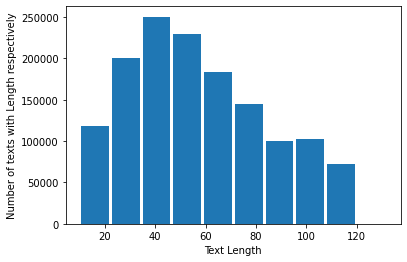

In [11]:
plt.hist(df['ques_len'], rwidth= 0.9 )
plt.xlabel("Text Length")
plt.ylabel("Number of texts with Length respectively")
plt.show();

---
####  By looking at the above histogram, we can see that More than 80% of the sentences have less than 100 characters.
---

--
### Q-4
--

---
#### Lets Make Two Columns: 1- for Len of Unique Characters , 2- for Unique Characters
---

In [12]:
dummy= df.copy()

In [13]:

dummy['unique_char'] = [ len(set(j)) for i, j in dummy['questions'].items()]  

In [14]:
dummy['unique_chars_used'] = [list(set(j)) for i, j in dummy['questions'].items()]

In [15]:
dummy.head(3)

,questions,ques_len,unique_char,unique_chars_used
0,why doesn't an optical mouse work on a glass t...,51,23,"[ , m, ?, w, o, r, d, g, e, l, u, b, a, c, k, ..."
1,What is the best off-road motorcycle trail ?,44,19,"[ , m, ?, f, o, -, W, r, d, e, l, b, a, c, h, ..."
2,What is Trans Fat? How to reduce that?,38,19,"[ , ?, w, o, H, W, r, T, F, d, e, u, a, c, h, ..."


In [16]:
# ATTENTION !!!  Our target is to get the unique characters present in all the questions! 

lst= []

for i, j in dummy['unique_chars_used'].items():
  lst+= j


In [17]:
( f"So there are total {len(set(lst))} Characters")

'So there are total 875 Characters'

---
#### The number are so high because beside English Alphabets, there are characters of other languages as well!
---

--
### Q- 9
--

In [18]:
import re

cleaned=[]
for i, j in dummy['questions'].items():
  cleaned.append(re.sub(r"[^A-Za-z.,!?@:;' ]", '', j)) 
  

In [19]:
# Dummy Data
dummy['cleaned'] = cleaned
# Real Data
df['cleaned'] = cleaned

In [20]:
df.head(3)

,questions,ques_len,cleaned
0,why doesn't an optical mouse work on a glass t...,51,why doesn't an optical mouse work on a glass t...
1,What is the best off-road motorcycle trail ?,44,What is the best offroad motorcycle trail ?
2,What is Trans Fat? How to reduce that?,38,What is Trans Fat? How to reduce that?


--
### Q- 10
--

In [21]:
cleaned= [ "^"+ j+ "$" for i, j in df['cleaned'].items()]

In [22]:
dummy['cleaned'] = cleaned
# real_data
df['cleaned'] = cleaned

In [23]:
df['cleaned'].head(10)

0    ^why doesn't an optical mouse work on a glass ...
1        ^What is the best offroad motorcycle trail ?$
2             ^What is Trans Fat? How to reduce that?$
3                         ^How many planes Fedex has?$
4    ^In the san francisco bay area, does it make s...
5           ^What's the best way to clean a keyboard?$
6     ^Why do people blush when they are embarrassed?$
7    ^Is Lin Qingxia aka Brigitte Lin the most beau...
8                      ^What is the origin of foobar?$
9                     ^How the human species evolved?$
Name: cleaned, dtype: object

---
Q- 11

---

In [24]:
df['unique_chars_used'] = [list(set(j)) for i, j in df['cleaned'].items()]

lst= []

for i, j in df['unique_chars_used'].items():
  lst+= j


print("Now the number of Unique Characters are : ", len(set(lst)))

Now the number of Unique Characters are :  63


## Part 3: Tokenization

To train a model on the questions, we must first convert them from text into vectors. To do this, we will use two useful TensorFlow preprocessing utilities: `tensorflow.keras.preprocessing.text.Tokenizer` and `tensorflow.keras.preprocessing.sequence.pad_sequences`.

We will first examine what these utilities do using this sample textual data:

In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

sample_texts = ['Hello world.', 'Hi ITC!']

**Questions:**

12. Create a tokenizer with `sample_tokenizer = Tokenizer(char_level=True)`. Fit it with `sample_tokenizer.fit_on_texts(sample_texts)` and then view the output of `sample_tokenizer.texts_to_sequences(sample_texts)`. Explain the meaning of the output.
13. Apply `pad_sequences` to the output from the previous question, using parameters `maxlen=10, padding='post', truncating='post'`. Explain what this does.

---
Q- 12

---

In [26]:
sample_tokenizer = Tokenizer(char_level= True)
sample_tokenizer.fit_on_texts(sample_texts)

In [27]:
sample_tokenizer.texts_to_sequences(sample_texts)

[[2, 6, 1, 1, 3, 4, 7, 3, 8, 1, 9, 10], [2, 5, 4, 5, 11, 12, 13]]

####  `So this Text_to_sequences transforms each sequences of String into an Array of integers of the same length as that of the characters in the String.`

---
Q-13

---

In [28]:
sequence= sample_tokenizer.texts_to_sequences(sample_texts)
#  So by looking at the doc of Pad_sequences() its clear that this function is used to Pdas the Sequence equal to the length of maxlen parameter (if provided) or the length of the longest sequences.
pad_result= pad_sequences(sequences=sequence, maxlen=10, padding= "post", truncating= 'post')
pad_result

array([[ 2,  6,  1,  1,  3,  4,  7,  3,  8,  1],
       [ 2,  5,  4,  5, 11, 12, 13,  0,  0,  0]], dtype=int32)

---
Q- 14

---

In [29]:
tokenizer = Tokenizer(char_level= True, lower= False )
tokenizer.fit_on_texts(df['cleaned'])
sequence= tokenizer.texts_to_sequences(df['cleaned'])

In [30]:
data= pad_sequences(sequences=sequence, maxlen=100, padding='post', truncating='post')
data.shape

(1400000, 100)

*  `Shape of the data is: (1400000, 100)`

In [31]:
data[0:1, 0:]

array([[19, 17, 10, 18,  1, 12,  3,  2,  8,  7, 34,  4,  1,  5,  7,  1,
         3, 23,  4,  6, 14,  5, 11,  1, 16,  3, 13,  8,  2,  1, 17,  3,
         9, 25,  1,  3,  7,  1,  5,  1, 21, 11,  5,  8,  8,  1,  4,  5,
        24, 11,  2, 15, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]], dtype=int32)

---
Q-15

---

In [32]:
print( "Minimum Number that appears in the Data is: " , data.min())
print( "Maximum Number that appears in the Data is: " , data.max())


Minimum Number that appears in the Data is:  0
Maximum Number that appears in the Data is:  63


In [33]:
print( "Number of unique characters used are: " ,np.unique(data))

Number of unique characters used are:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


#### As we can the that the number of unique numbers are same as that of number of unique characters in the question 11. 
#### The reason is
  * By applying tokenizer on the questions, each character was converted to a unique number. So because of that new array also has same number of unique characters

---
Q- 16

---

In [34]:
data[-1]

array([19, 17, 10,  2,  9,  2,  1, 14,  5,  7,  1,  6,  1, 22,  6,  7, 12,
        1, 17,  2, 24,  8,  6,  4,  2,  8,  1,  1, 17,  2,  9,  2,  1,  6,
        1, 14,  5,  7,  1, 10,  5, 26,  2,  1,  5,  1, 26,  6,  9,  4, 13,
        5, 11,  1, 23,  2,  4, 15, 15, 20,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

## Part 4: Data Preparation

Now we will use the utilities from above to prepare our data in numeric form.

**Questions:**
14. Using `Tokenizer` and `pad_sequences()`, convert the textual data in `df.cleaned` to a NumPy matrix `data`. Use the following parameters:
  * `Tokenizer`: `char_level=True`, `lower=False` (don't convert texts to lowercase)
  * `pad_sequences()`: `maxlen=100`, `padding='post'`, `truncating='post'`
  
  What is the shape of `data`?

15. What are the minimum and maximum numbers that appear in `data`? How many unique numbers appear in `data`? How does this compare to question 11, and why?

16. Use `data` to generate input and target matrices `X` and `Y` for our RNN language model. `X` and `Y` should be arrays of character indices of shape `(1400000, 99).`

  Note: `Y` should be offset one character from `X` since we want to predict the next character in a string given what came before - e.g. the first row of `X` is the *first* 99 characters of the first question in `data`, and the first row of `Y` is the *last* 99 characters of the same question.

  In other words, if `X[0]` equals `[25, 44,  2,  1,  9, 13, ...]`, then `Y[0]` equals `[44, 2, 1, 9, 13, ...]`.

In [35]:
data[:, 1:].shape

(1400000, 99)

## Part 5: Language Modeling

We will now build a character-level RNN language model that can learn from the given data.

**Questions:**

17.  Build a Sequential model `model` with the following three layers:
  * Embedding layer (`tensorflow.keras.layers.Embedding(...)`) with output dimension `256`. Use `mask_zero=True` since we zero-padded the input, and set `input_length=99` and `input_dim=64` to match the dimensions of X and the number of possible values that features in X can take.
  * LSTM layer with hidden state dimension `1024`. Use `return_sequences=True` to make the layer output a vector for every time step.
  * Fully-connected (`Dense(64, ...)`) layer with softmax activation applied to each LSTM output.

    Hint: Use `model.input_shape`, `model.output_shape`, and `model.summary()` to make sure your layer shapes are correct.

18. Briefly explain why we used `input_length=99` and `input_dim=64` in the question above.

19. Compile the model with loss function `'sparse_categorical_crossentropy'` and Adam optimizer. Examine the model's layers with `model.summary()`. How do you interpret the output of the final layer?

---
Q- 17

---

In [36]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

In [37]:
model= Sequential()
model.add(layers.Embedding( input_dim= 64, output_dim= 256,input_length= 99, mask_zero= True))
# Add LSTM Layer with 1024 hidden units
model.add(layers.LSTM(1024, return_sequences= True))
# Add a Dense Layer
model.add(layers.Dense(64, activation='softmax'))

In [38]:
model.input_shape , model.output_shape

((None, 99), (None, 99, 64))

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 99, 256)           16384     
                                                                 
 lstm (LSTM)                 (None, 99, 1024)          5246976   
                                                                 
 dense (Dense)               (None, 99, 64)            65600     
                                                                 
Total params: 5,328,960
Trainable params: 5,328,960
Non-trainable params: 0
_________________________________________________________________


---
Q- 18

---

#####  We have used the input length 99, as we want the input to be always one less then the output

In [40]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 99, 256)           16384     
                                                                 
 lstm (LSTM)                 (None, 99, 1024)          5246976   
                                                                 
 dense (Dense)               (None, 99, 64)            65600     
                                                                 
Total params: 5,328,960
Trainable params: 5,328,960
Non-trainable params: 0
_________________________________________________________________


##  Part 6: Generating questions

Now we will train our language model and use it to generate Yahoo! Answers questions.

We can generate a question using our model as follows:
* Start with the beginning-of-string token `'^'` as the initial input. Hint: Use `tokenizer.word_index`.
* Predict the distribution of the next character using `model.predict(...)` and use the distribution to select the next character in the question with `np.random.choice(..., p=...)`. Hint: Use `tokenizer.index_word`.
* Repeat the process until the end-of-string token `'$'` is predicted or until 100 characters are generated
* Remove `^` from the beginning and `$` from the end of the generated string.

**Questions:**
20. Make a function `generate_text()` that returns the string of a question generated by the model, using the above procedure. What does its output look like (before the model is trained)?
21. Train the model on X and Y with `validation_split=0.1`. (recommended setting: `batch_size=64`). Generate and print out a question using the model every 5000 minibatches, using the Keras Callback in the code provided below. What do you see?
22. Train the model for at least one epoch. Verify that the generated texts look interesting after training. (As a bonus you may train for more epochs, e.g. using EarlyStopping, but this will take a significant amount of time.)
23. Print out 20 randomly generated questions from your final model.
24. Use https://www.tweetgen.com/create/tweet.html with your best generated question to format it as a tweet, and post it to the class Slack channel.

You can now fool your family and friends with your best randomly-generated Yahoo! Answers question!

25. (BONUS) For an extra challenge, you can try implementing some well-known improvements to neural text generation models, using the paper [Holtzman et al. (2020) The Curious Case of Neural Text Degeneration](https://arxiv.org/pdf/1904.09751.pdf)
  * **Temperature**:  For temperature parameter $t$, at each step we sample the character next $c$ using probabilities proportional to $p_c^{1/t}$, where $p_c$ is the probability of sampling character $c$ when not using temperature. You may parameter `temperature=` to `generate_text()`, and should see that passing values less than `1` generates questions that look very clean, while values greater than `1` makes chaotic-looking questions. (see p. 6 in the paper)
  * **Nucleus Sampling**: See pp. 4-5 in the paper for the definition of this method.

---
### Part -6
---

In [42]:
tokenizer.word_index['^']

19

---
Q- 20 

---

In [ ]:
text=[]
def generate_text():
  for i in range(0, 100):
    distribution= model.predict()
    text.append(np.random.choice(distribution, p= tokenizer.word_index))


  return re.sub(r"[^A-Za-z.,!?@:;' ]", '', text)

---
Q- 21

---

In [ ]:
model.fit(X,y, validation_split=0.1, batch_size=64)

---
Q- 23

---

In [ ]:
# CODE FOR QUESTION 21
from tensorflow.keras.callbacks import Callback

class GenerateTextCB(Callback):
  def on_train_batch_end(self, batch, logs=None):
    if batch % 5000 == 0:
      print()
      print(f'Generated text for training batch {batch}:')
  
      print(generate_text())
      print()

In [ ]:
for i in range(0, 20):
  return generate_text()